In [2]:
import math
import random
from copy import deepcopy
from itertools import combinations

import numpy as np
import pandas as pd
import networkx as nx

from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import scipy as sp
import scipy.stats as stats
from scipy.stats import norm, beta, cauchy, expon, rayleigh, uniform, multivariate_t, t, rankdata, kendalltau, pearsonr
from scipy.stats.mstats import spearmanr
import scipy.integrate as integrate
from scipy.optimize import brentq, fsolve

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [ ]:
def adjust_sd_for_centrality(index, target=.5, tolerance=0.05, max_iterations=100, n=100000, n_rvs=6):
    """
    Adjusts the standard deviation of one variable to achieve a desired change in eigenvector centrality using NumPy.

    Parameters:
    - data: np.ndarray, dataset where columns are variables
    - index: int, index of the variable to adjust
    - target: float, desired eigen centrality proportion for the variable at 'index' (range 0 to 1)
    - tolerance: float, tolerance level for centrality adjustment
    - max_iterations: int, maximum number of iterations to try adjustments

    Returns:
    - updated_data: np.ndarray, the adjusted dataset
    - success: bool, whether the target centrality was achieved within the tolerance
    """

    set_seeds()

    sds = np.array([1, .5, .5, .5, .5, .5])

    rvs = []
    cumsum_rv = np.zeros(n)
    for i in range(n_rvs):
        current_rv = cumsum_rv + np.random.normal(loc=0, scale=sds[i], size=n)
        cumsum_rv = current_rv.copy()
        rvs.append(current_rv)

    eigen_centralities = eigen_centrality(np.corrcoef(rvs))
    eigen_centralities_norm = eigen_centralities / eigen_centralities.sum()
    current_centrality = eigen_centralities_norm[index]

    for _ in range(max_iterations):
        if abs(current_centrality - target) < tolerance:
            return data, True
        
        # Adjust the standard deviation
        sd_factor = target / current_centrality
        sds[index] /= sd_factor

        # Resimulate
        rvs = []
        cumsum_rv = np.zeros(n)
        for i in range(n_rvs):
            current_rv = cumsum_rv + np.random.normal(loc=0, scale=sds[i], size=n)
            cumsum_rv = current_rv.copy()
            rvs.append(current_rv)

        # Recompute the correlation matrix and centrality
        eigen_centralities = eigen_centrality(np.corrcoef(rvs))
        eigen_centralities_norm = eigen_centralities / eigen_centralities.sum()
        current_centrality = eigen_centralities_norm[index]

    return sds, eigen_centralities

In [ ]:
# Example usage
np.random.seed(0)
data = np.random.normal(size=(1000, 5))  # 1000 observations of 5 variables
target_centrality = 0.5
adjusted_data, success = adjust_std_for_centrality(data, index=0, target_centrality=target_centrality)
print("Adjustment Success:", success)


Small Correlation Matrix Generation

In [ ]:
set_seeds()

n = 100000
n_rvs = 6

sds = np.array([1, .1, .5, .5, .5, .5])

rvs = []
cumsum_rv = np.zeros(n)
for i in range(n_rvs):
    current_rv = cumsum_rv + np.random.normal(loc=0, scale=sds[i], size=n)
    cumsum_rv = current_rv.copy()
    rvs.append(current_rv)

# np.round(np.corrcoef(rvs)*100)/100

x1 = np.random.normal(loc=0, scale=1, size=n)
x2 = np.random.normal(loc=0, scale=1, size=n)
x3 = x1 + np.random.normal(loc=0, scale=1, size=n)
x4 = x2 + np.random.normal(loc=0, scale=1, size=n)
x5 = x1 + x2 + x3 + x4 + np.random.normal(loc=0, scale=.5, size=n)
x6 = x5 + np.random.normal(loc=0, scale=10, size=n)

# np.round(100*np.corrcoef([x1,x2,x3,x4,x5,x6]))/100, eigen_centrality(np.corrcoef([x1,x2,x3,x4,x5,x6])) / eigen_centrality(np.corrcoef([x1,x2,x3,x4,x5,x6])).sum()

Feature Generation with Nonlinear Dependencies using Copulas

In [ ]:
set_seeds()

U_norm = norm.cdf(features_linear)
H = np.empty_like(U_norm)
alphas = (np.random.uniform(size=d) + 1)/2
betas = (np.random.uniform(size=d) + 1)/2
for i in range(d):
    H[:,i] = beta.ppf(U_Gauss[:,i], np.abs(np.random.normal(4,2)), np.abs(np.random.normal(8,5)))

# set_seeds()

# d = correlation.shape[0]
# A = np.linalg.cholesky(correlation)
# sds = np.linspace(.1,1,d)*10 # np.ones(d)
# Z = np.random.normal(0, sds, size=(n_samples,d))
# U_Gauss = norm.cdf(np.matmul(Z, A))
# H = np.empty_like(U_Gauss)
# alphas = np.random.uniform(size=d)
# betas = np.random.uniform(size=d)
# for i in range(d):
#     H[:,i] = beta.ppf(U_Gauss[:,i], alphas[i], betas[i])

# plt.figure(figsize=(6,6))

# var1 = 2
# var2 = 7

# plt.subplot(2,2,1)
# plt.scatter(H[:,var1], H[:,var2], alpha=0.2)
# t = kendalltau(H[:,var1], H[:,var2])
# plt.title(r'$\rho=%0.02f \ \tau=%0.02f$' % (pearsonr(H[:,var1], H[:,var2])[0], t.correlation))
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
# plt.xlabel('X')
# plt.ylabel('Y')

# plt.tight_layout()

c:\Users\Jared\anaconda3\envs\interpretable\Lib\site-packages\scipy\stats\_continuous_distns.py:700: RuntimeWarning: Error in function boost::math::tools::newton_raphson_iterate<d>: There appears to be no root to be found in boost::math::tools::newton_raphson_iterate, perhaps we have a local minima near current best guess of %1%
  return _boost._beta_ppf(q, a, b)
c:\Users\Jared\anaconda3\envs\interpretable\Lib\site-packages\scipy\stats\_continuous_distns.py:700: RuntimeWarning: Error in function boost::math::ibeta<d>(%1%, %1%, %1%): Root finding evaluation exceeded %1% iterations, giving up now.
  return _boost._beta_ppf(q, a, b)


Nonlinear Dependency Visualization

In [ ]:
for entropy, corr in list(eigen_entropy_to_corr.items())[:1]:
    linear_features = generate_linear_features(correlation)
    y_lin_from_lin, y_nonlin_from_lin = generate_from_linear(linear_features)
    nonlinear_features, y_lin_from_nonlin, y_nonlin_from_nonlin = generate_from_nonlinear(generate_linear_features(correlation))

Standardize

In [ ]:
for col in range(linear_features.shape[1]):
    linear_features[:,col] = (linear_features[:,col] - linear_features[:,col].mean()) / linear_features[:,col].std()
    nonlinear_features[:,col] = (nonlinear_features[:,col] - nonlinear_features[:,col].mean()) / nonlinear_features[:,col].std()
    y_lin_from_lin = (y_lin_from_lin - y_lin_from_lin.mean()) / y_lin_from_lin.std()
    y_nonlin_from_lin = (y_nonlin_from_lin - y_nonlin_from_lin.mean()) / y_nonlin_from_lin.std()
    y_lin_from_nonlin = (y_lin_from_nonlin - y_lin_from_nonlin.mean()) / y_lin_from_nonlin.std()
    y_nonlin_from_nonlin = (y_nonlin_from_nonlin - y_nonlin_from_nonlin.mean()) / y_nonlin_from_nonlin.std()

Tensor Conversion

In [ ]:
# Linear features
X_linear_t = torch.tensor(linear_features, dtype=torch.float32)
y_lin_from_lin_t, y_nonlin_from_lin_t = torch.tensor(y_lin_from_lin, dtype=torch.float32), torch.tensor(y_nonlin_from_lin, dtype=torch.float32)

# Split the data into training and testing sets
train_ratio = 0.8
train_size = int(train_ratio * n_samples)
X_linear_train, X_linear_test = X_linear_t[:train_size], X_linear_t[train_size:]
y_lin_from_lin_train, y_lin_from_lin_test = y_lin_from_lin_t[:train_size], y_lin_from_lin_t[train_size:]
y_nonlin_from_lin_train, y_nonlin_from_lin_test = y_nonlin_from_lin_t[:train_size], y_nonlin_from_lin_t[train_size:]

# Nonlinear features
X_nonlinear_t = torch.tensor(nonlinear_features, dtype=torch.float32)
y_lin_from_nonlin_t, y_nonlin_from_nonlin_t = torch.tensor(y_lin_from_nonlin, dtype=torch.float32), torch.tensor(y_nonlin_from_nonlin, dtype=torch.float32)

# Split the data into training and testing sets
train_ratio = 0.8
train_size = int(train_ratio * n_samples)
X_nonlinear_train, X_nonlinear_test = X_nonlinear_t[:train_size], X_nonlinear_t[train_size:]
y_lin_from_nonlin_train, y_lin_from_nonlin_test = y_lin_from_nonlin_t[:train_size], y_lin_from_nonlin_t[train_size:]
y_nonlin_from_nonlin_train, y_nonlin_from_nonlin_test = y_nonlin_from_nonlin_t[:train_size], y_nonlin_from_nonlin_t[train_size:]

# Define the loss function (Mean Squared Error)
criterion1 = nn.MSELoss()
criterion2 = nn.MSELoss()
criterion3 = nn.MSELoss()
criterion4 = nn.MSELoss()

# Define the optimizer (Stochastic Gradient Descent)
optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01)
optimizer3 = optim.SGD(model3.parameters(), lr=0.01)
optimizer4 = optim.SGD(model4.parameters(), lr=0.01)

In [ ]:
# Train the model
num_epochs = 2000
for epoch in range(num_epochs):

    # Forward pass
    outputs1 = model1(X_linear_train)  
    outputs2 = model2(X_linear_train)  
    outputs3 = model3(X_nonlinear_train)  
    outputs4 = model4(X_nonlinear_train)  

    # Compute the loss
    loss1 = criterion1(outputs1, y_lin_from_lin_train)  
    loss2 = criterion2(outputs2, y_nonlin_from_lin_train)
    loss3 = criterion3(outputs3, y_lin_from_nonlin_train)
    loss4 = criterion4(outputs4, y_nonlin_from_nonlin_train)

    # Zero the gradients (default behavior accumulates gradients)
    optimizer1.zero_grad() 
    optimizer2.zero_grad() 
    optimizer3.zero_grad()
    optimizer4.zero_grad()

    # Backward pass (through backprop)
    loss1.backward()  
    loss2.backward()  
    loss3.backward()  
    loss4.backward()  

    # Update the weights
    optimizer1.step()  
    optimizer2.step() 
    optimizer3.step() 
    optimizer4.step() 

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss1: {loss1.item():.4f}')
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss2: {loss2.item():.4f}')
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss3: {loss3.item():.4f}')
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss4: {loss4.item():.4f}')
        print('\n')


Epoch [100/2000], Loss1: 0.6684
Epoch [100/2000], Loss2: 0.9993
Epoch [100/2000], Loss3: 0.0434
Epoch [100/2000], Loss4: 1.2222


Epoch [200/2000], Loss1: 0.1836
Epoch [200/2000], Loss2: 0.9884
Epoch [200/2000], Loss3: 0.0327
Epoch [200/2000], Loss4: 1.2059


Epoch [300/2000], Loss1: 0.1574
Epoch [300/2000], Loss2: 0.9723
Epoch [300/2000], Loss3: 0.0241
Epoch [300/2000], Loss4: 1.1971


Epoch [400/2000], Loss1: 0.1502
Epoch [400/2000], Loss2: 0.9459
Epoch [400/2000], Loss3: 0.0180
Epoch [400/2000], Loss4: 1.1924


Epoch [500/2000], Loss1: 0.1456
Epoch [500/2000], Loss2: 0.8987
Epoch [500/2000], Loss3: 0.0143
Epoch [500/2000], Loss4: 1.1890


Epoch [600/2000], Loss1: 0.1423
Epoch [600/2000], Loss2: 0.8084
Epoch [600/2000], Loss3: 0.0123
Epoch [600/2000], Loss4: 1.1861


Epoch [700/2000], Loss1: 0.1398
Epoch [700/2000], Loss2: 0.6390
Epoch [700/2000], Loss3: 0.0112
Epoch [700/2000], Loss4: 1.1836


Epoch [800/2000], Loss1: 0.1380
Epoch [800/2000], Loss2: 0.3933
Epoch [800/2000], Loss3: 0

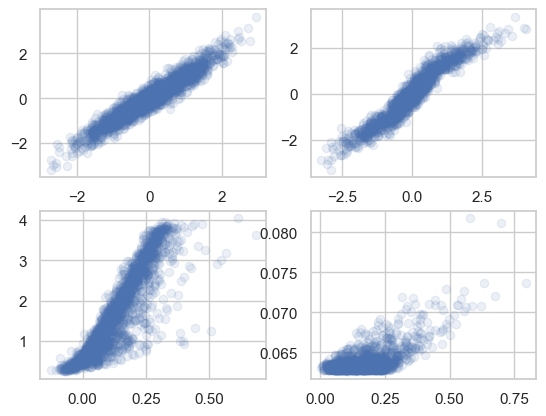

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2)

preds = [[model1(X_linear_test).detach().numpy().flatten(), model2(X_linear_test).detach().numpy().flatten()], 
         [model3(X_nonlinear_test).detach().numpy().flatten(), model4(X_nonlinear_test).detach().numpy().flatten()]]

obs = [[y_lin_from_lin_test.flatten(), y_nonlin_from_lin_test.flatten()], 
       [y_lin_from_nonlin_test.flatten(), y_nonlin_from_nonlin_test.flatten()]]

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.plot(preds[i][j], obs[i][j], 'o', alpha=.1)

LRP Actual Results

In [ ]:
models = [model1,model2,model3,model4]

explanations = []
for model in models:

    W_ = [model.state_dict()['layers.0.weight'].numpy(), model.state_dict()['layers.2.weight'].numpy(), model.state_dict()['layers.4.weight'].numpy()]
    B_ = [model.state_dict()['layers.0.bias'].numpy(), model.state_dict()['layers.2.bias'].numpy(), model.state_dict()['layers.4.bias'].numpy()]
    L_ = len(W_)
    A_ = [linear_features] + [None]*L

    # Forward pass
    for l in range(L_):
        A_[l+1] = relu(A_[l].dot(W_[l].T) + B_[l])
    R_ = [None]*L_ + [A_[L_]]

    # Top layers

    # Loop through but stop before l = 0
    for l in range(L_-1,0,-1):

        # Extra Rules
        rho_w = rho(W_[l].T,l)
        rho_b = rho(B_[l],l)

        # Four LRP steps
        z = incr(A_[l].dot(rho_w) + rho_b,l) # step 1: forward pass
        s = R_[l+1] / z # step 2: elementwise division
        c = s.dot(rho_w.T) # step 3: backward pass
        R_[l] = A_[l]*c # step 4: elementwise product

    # Input Layer

    # Apply the first layer w^2 rule for continuous tabular data
    w  = W_[0].T
    w_sqr = w**2

    # Four LRP steps
    z = (w**2).sum() # step 1: forward pass
    s = R_[1] / z # step 2: elementwise division
    c = s.dot(w_sqr.T) # step 3: backward pass
    R_[0] = c # step 4: elementwise product
    explanation = R_[0].tolist()
    explanations.append(explanation)
explanations = np.array(explanations).reshape(2,2,10000,10)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2)

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.imshow(explanations[i,j,:200,:], aspect='auto')

plt.savefig("explanations_template.png")

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2)

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.imshow(explanations[i,j,outlier_indices,:], aspect='auto')

plt.savefig("outliers.png")

All explanations

Epoch [100/2000], Loss1: 0.8278
Epoch [100/2000], Loss2: 1.1208
Epoch [100/2000], Loss3: 0.2826
Epoch [100/2000], Loss4: 0.8382


Epoch [200/2000], Loss1: 0.8261
Epoch [200/2000], Loss2: 1.1178
Epoch [200/2000], Loss3: 0.2762
Epoch [200/2000], Loss4: 0.8261


Epoch [300/2000], Loss1: 0.8247
Epoch [300/2000], Loss2: 1.1149
Epoch [300/2000], Loss3: 0.2711
Epoch [300/2000], Loss4: 0.8193


Epoch [400/2000], Loss1: 0.8234
Epoch [400/2000], Loss2: 1.1117
Epoch [400/2000], Loss3: 0.2669
Epoch [400/2000], Loss4: 0.8162


Epoch [500/2000], Loss1: 0.8223
Epoch [500/2000], Loss2: 1.1080
Epoch [500/2000], Loss3: 0.2638
Epoch [500/2000], Loss4: 0.8142


Epoch [600/2000], Loss1: 0.8213
Epoch [600/2000], Loss2: 1.1039
Epoch [600/2000], Loss3: 0.2616
Epoch [600/2000], Loss4: 0.8126


Epoch [700/2000], Loss1: 0.8203
Epoch [700/2000], Loss2: 1.0993
Epoch [700/2000], Loss3: 0.2601
Epoch [700/2000], Loss4: 0.8111


Epoch [800/2000], Loss1: 0.8194
Epoch [800/2000], Loss2: 1.0942
Epoch [800/2000], Loss3: 0

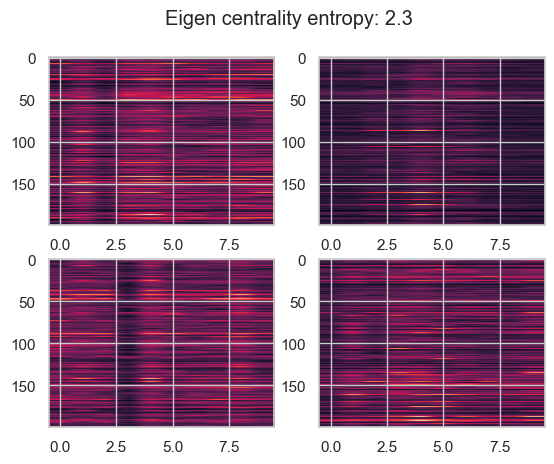

<Figure size 640x480 with 0 Axes>

In [ ]:
for entropy, corr in list(eigen_entropy_to_corr.items())[:1]:
    
    linear_features, outlier_indices = generate_linear_features(correlation)
    y_lin_from_lin, y_nonlin_from_lin = generate_from_linear(linear_features, outlier_indices=outlier_indices)
    nonlinear_features, y_lin_from_nonlin, y_nonlin_from_nonlin = generate_from_nonlinear(linear_features, outlier_indices=outlier_indices)

    for col in range(linear_features.shape[1]):
        linear_features[:,col] = (linear_features[:,col] - linear_features[:,col].mean()) / linear_features[:,col].std()
        nonlinear_features[:,col] = (nonlinear_features[:,col] - nonlinear_features[:,col].mean()) / nonlinear_features[:,col].std()
        y_lin_from_lin = (y_lin_from_lin - y_lin_from_lin.mean()) / y_lin_from_lin.std()
        y_nonlin_from_lin = (y_nonlin_from_lin - y_nonlin_from_lin.mean()) / y_nonlin_from_lin.std()
        y_lin_from_nonlin = (y_lin_from_nonlin - y_lin_from_nonlin.mean()) / y_lin_from_nonlin.std()
        y_nonlin_from_nonlin = (y_nonlin_from_nonlin - y_nonlin_from_nonlin.mean()) / y_nonlin_from_nonlin.std()

    model1 = BasicRegressionNN(input_size, hidden_sizes, output_size)
    model2 = BasicRegressionNN(input_size, hidden_sizes, output_size)
    model3 = BasicRegressionNN(input_size, hidden_sizes, output_size)
    model4 = BasicRegressionNN(input_size, hidden_sizes, output_size)

    # Linear features
    X_linear_t = torch.tensor(linear_features, dtype=torch.float32)
    y_lin_from_lin_t, y_nonlin_from_lin_t = torch.tensor(y_lin_from_lin, dtype=torch.float32), torch.tensor(y_nonlin_from_lin, dtype=torch.float32)

    # Split the data into training and testing sets
    train_ratio = 0.8
    train_size = int(train_ratio * n_samples)
    X_linear_train, X_linear_test = X_linear_t[:train_size], X_linear_t[train_size:]
    y_lin_from_lin_train, y_lin_from_lin_test = y_lin_from_lin_t[:train_size], y_lin_from_lin_t[train_size:]
    y_nonlin_from_lin_train, y_nonlin_from_lin_test = y_nonlin_from_lin_t[:train_size], y_nonlin_from_lin_t[train_size:]

    # Nonlinear features
    X_nonlinear_t = torch.tensor(nonlinear_features, dtype=torch.float32)
    y_lin_from_nonlin_t, y_nonlin_from_nonlin_t = torch.tensor(y_lin_from_nonlin, dtype=torch.float32), torch.tensor(y_nonlin_from_nonlin, dtype=torch.float32)

    # Split the data into training and testing sets
    train_ratio = 0.8
    train_size = int(train_ratio * n_samples)
    X_nonlinear_train, X_nonlinear_test = X_nonlinear_t[:train_size], X_nonlinear_t[train_size:]
    y_lin_from_nonlin_train, y_lin_from_nonlin_test = y_lin_from_nonlin_t[:train_size], y_lin_from_nonlin_t[train_size:]
    y_nonlin_from_nonlin_train, y_nonlin_from_nonlin_test = y_nonlin_from_nonlin_t[:train_size], y_nonlin_from_nonlin_t[train_size:]

    # Define the loss function (Mean Squared Error)
    criterion1 = nn.MSELoss()
    criterion2 = nn.MSELoss()
    criterion3 = nn.MSELoss()
    criterion4 = nn.MSELoss()

    # Define the optimizer (Stochastic Gradient Descent)
    optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
    optimizer2 = optim.SGD(model2.parameters(), lr=0.01)
    optimizer3 = optim.SGD(model3.parameters(), lr=0.01)
    optimizer4 = optim.SGD(model4.parameters(), lr=0.01)

    # Train the model
    num_epochs = 2000
    for epoch in range(num_epochs):

        # Forward pass
        outputs1 = model1(X_linear_train)  
        outputs2 = model2(X_linear_train)  
        outputs3 = model3(X_nonlinear_train)  
        outputs4 = model4(X_nonlinear_train)  

        # Compute the loss
        loss1 = criterion1(outputs1, y_lin_from_lin_train)  
        loss2 = criterion2(outputs2, y_nonlin_from_lin_train)
        loss3 = criterion3(outputs3, y_lin_from_nonlin_train)
        loss4 = criterion4(outputs4, y_nonlin_from_nonlin_train)

        # Zero the gradients (default behavior accumulates gradients)
        optimizer1.zero_grad() 
        optimizer2.zero_grad() 
        optimizer3.zero_grad()
        optimizer4.zero_grad()

        # Backward pass (through backprop)
        loss1.backward()  
        loss2.backward()  
        loss3.backward()  
        loss4.backward()  

        # Update the weights
        optimizer1.step()  
        optimizer2.step() 
        optimizer3.step() 
        optimizer4.step() 

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss1: {loss1.item():.4f}')
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss2: {loss2.item():.4f}')
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss3: {loss3.item():.4f}')
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss4: {loss4.item():.4f}')
            print('\n')

    models = [model1,model2,model3,model4]

    explanations = []
    for model in models:

        W_ = [model.state_dict()['layers.0.weight'].numpy(), model.state_dict()['layers.2.weight'].numpy(), model.state_dict()['layers.4.weight'].numpy()]
        B_ = [model.state_dict()['layers.0.bias'].numpy(), model.state_dict()['layers.2.bias'].numpy(), model.state_dict()['layers.4.bias'].numpy()]
        L_ = len(W_)
        A_ = [linear_features] + [None]*L

        # Forward pass
        for l in range(L_):
            A_[l+1] = relu(A_[l].dot(W_[l].T) + B_[l])
        R_ = [None]*L_ + [A_[L_]]

        # Top layers

        # Loop through but stop before l = 0
        for l in range(L_-1,0,-1):

            # Extra Rules
            rho_w = rho(W_[l].T,l)
            rho_b = rho(B_[l],l)

            # Four LRP steps
            z = incr(A_[l].dot(rho_w) + rho_b,l) # step 1: forward pass
            s = R_[l+1] / z # step 2: elementwise division
            c = s.dot(rho_w.T) # step 3: backward pass
            R_[l] = A_[l]*c # step 4: elementwise product

        # Input Layer

        # Apply the first layer w^2 rule for continuous tabular data
        w  = W_[0].T
        w_sqr = w**2

        # Four LRP steps
        z = (w**2).sum() # step 1: forward pass
        s = R_[1] / z # step 2: elementwise division
        c = s.dot(w_sqr.T) # step 3: backward pass
        R_[0] = c # step 4: elementwise product
        explanation = R_[0].tolist()
        explanations.append(explanation)
    explanations = np.array(explanations).reshape(2,2,10000,10)


    fig, ax = plt.subplots(nrows=2, ncols=2)

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            col.imshow(explanations[i,j,:200,:], aspect='auto')
    
    fig.suptitle(f"Eigen centrality entropy: {entropy}")
    
    plt.show()

    plt.savefig(f"explanations_entropy_{entropy}.png")
